<a href="https://colab.research.google.com/github/harshdsdh/sparseLP/blob/main/GCN_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install networkx
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn.functional as F
import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from torch.nn import Linear
from torch_geometric.datasets import Planetoid


from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
from tqdm import tqdm

In [8]:
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx, to_networkx
import pandas as pd

In [9]:
param_grid = {
    'hidden_channels': [4, 8, 16, 32, 64, 128, 256, 512],
}

pyg_cora = Planetoid(root='/tmp/Cora', name='Cora')[0]
G_full = nx.Graph()
edge_list = pyg_cora.edge_index.t().cpu().numpy()
G_full.add_edges_from(edge_list)

data = from_networkx(G_full)
data.x = torch.eye(data.num_nodes)

Processing...
Done!


In [10]:
class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=1)

In [11]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.forward(data.x, data.edge_index)
    pred = model.decode(z, data.edge_label_index)
    loss = F.binary_cross_entropy_with_logits(pred, data.edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)
        pred = model.decode(z, data.edge_label_index).sigmoid().cpu().numpy()
    y_true = data.edge_label.cpu().numpy()
    auc = roc_auc_score(y_true, pred)
    ap = average_precision_score(y_true, pred)
    return auc, ap

In [ ]:
results = []
loss_curves = {}

for run in range(10):
  print(f'run {run}')
  transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=True,neg_sampling_ratio=2)
  train_data, val_data, test_data = transform(data)

  for hidden in param_grid['hidden_channels']:

    model = GCNLinkPredictor(data.num_features, hidden)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []
    for epoch in range(75):

      loss = train(model, optimizer, train_data)
      losses.append(loss)

    auc, ap = test(model, test_data)
    results.append({
        'run': run,
        'hidden': hidden,
        'auc': auc,
        'average_precision': ap
    })

    loss_curves[(run, hidden)] = losses

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9


In [1]:
df = pd.DataFrame(results)
df_res = df.groupby(['hidden'])[['auc', 'average_precision']].mean()
print(df.groupby(['hidden'])[['auc', 'average_precision']].mean())

NameError: name 'pd' is not defined

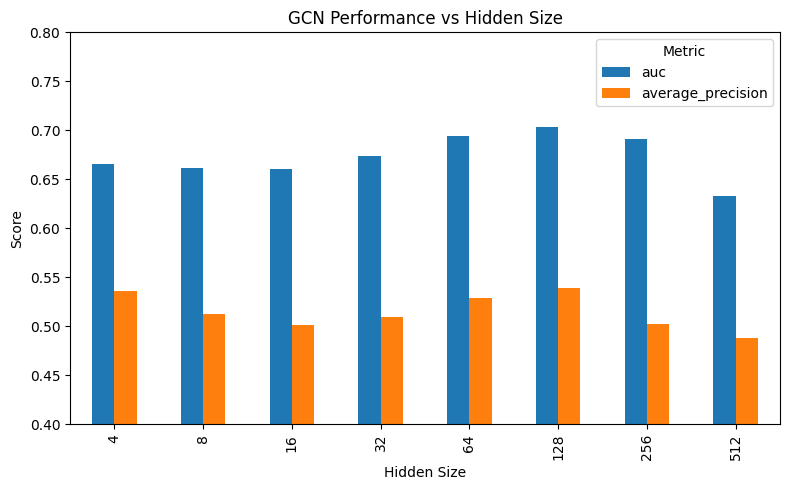

In [ ]:
ax = df_res.plot(kind='bar', figsize=(8, 5))
plt.title("GCN Performance vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Score")
plt.ylim(0.4, 0.8)

plt.legend(title="Metric")
plt.tight_layout()
plt.show()

In [12]:
def compute_bonus(u, v, data):
  try:
      Cu = data.nodes[u].get('community')
      Cv = data.nodes[v].get('community')
      if Cu == Cv:
          return 0

      deg_u = data.degree(u)
      deg_v = data.degree(v)

      nodes_Cu = [n for n in data.nodes if data.nodes[n].get('community') == Cu]
      avg_deg_Cu = np.mean([data.degree(n) for n in nodes_Cu]) if nodes_Cu else 0

      nodes_Cv = [n for n in data.nodes if data.nodes[n].get('community') == Cv]
      avg_deg_Cv = np.mean([data.degree(n) for n in nodes_Cv]) if nodes_Cv else 0

      if deg_u < avg_deg_Cu and deg_v > avg_deg_Cv:
          return len(list(nx.common_neighbors(data, u, v)))
      if deg_v < avg_deg_Cv and deg_u > avg_deg_Cu:
          return len(list(nx.common_neighbors(data, u, v)))
  except:
      return 0
  return 0

In [13]:
def train_modified(model, optimizer, data, nxGraph, bonus_weight):



  model.train()
  optimizer.zero_grad()
  z = model.forward(data.x, data.edge_index)
  pred = model.decode(z, data.edge_label_index)
  loss = F.binary_cross_entropy_with_logits(pred, data.edge_label)

  pos_edges = data.edge_label_index[:, data.edge_label == 1].T
  bonus = 0.0
  for u, v in pos_edges.tolist():
      bonus += compute_bonus(u, v, nxGraph)

  loss = loss - bonus_weight * bonus


  loss.backward()
  optimizer.step()
  return loss.item()

def test_modified(model, data):
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)
        pred = model.decode(z, data.edge_label_index).sigmoid().cpu().numpy()
    y_true = data.edge_label.cpu().numpy()
    auc = roc_auc_score(y_true, pred)
    ap = average_precision_score(y_true, pred)
    return auc, ap

In [14]:
param_grid = {
    'hidden_channels': [8, 32, 64, 128, 256],
    'bonus_weight': [0, 0.001, 0.01, 0.1]
}

pyg_cora = Planetoid(root='/tmp/Cora', name='Cora')[0]
G_full = nx.Graph()
edge_list = pyg_cora.edge_index.t().cpu().numpy()
G_full.add_edges_from(edge_list)

data = from_networkx(G_full)
data.x = torch.eye(data.num_nodes)

In [ ]:
results = []
loss_curves = {}

for run in range(10):
  print(f'run {run}')
  transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=True,neg_sampling_ratio=2)
  train_data, val_data, test_data = transform(data)

  G_train_nx = to_networkx(train_data, to_undirected=True)
  communities = nx.community.louvain_communities(G_train_nx)

  # Map nodes to communities
  community_map = {}
  for i, comm in enumerate(communities):
      for node in comm:
          community_map[node] = i

  # Add community attribute to nodes
  for node in G_train_nx.nodes():
      G_train_nx.nodes[node]['community'] = community_map.get(node, 0)


  for hidden in param_grid['hidden_channels']:
    for w in param_grid['bonus_weight']:

      model = GCNLinkPredictor(data.num_features, hidden)
      optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
      losses = []
      for epoch in range(75):

        loss = train_modified(model, optimizer, train_data,G_train_nx,  w)
        losses.append(loss)

      auc, ap = test_modified(model, test_data)
      results.append({
          'run': run,
          'hidden': hidden,
          'bonus_w': w,
          'auc': auc,
          'average_precision': ap
      })

      loss_curves[(run, hidden, w)] = losses

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8


In [19]:
results

[{'run': 0,
  'hidden': 8,
  'bonus_w': 0,
  'auc': np.float64(0.6586323308101794),
  'average_precision': np.float64(0.5071259677734135)},
 {'run': 0,
  'hidden': 8,
  'bonus_w': 0.001,
  'auc': np.float64(0.670615664517868),
  'average_precision': np.float64(0.5465755683751115)},
 {'run': 0,
  'hidden': 8,
  'bonus_w': 0.01,
  'auc': np.float64(0.6639251139911503),
  'average_precision': np.float64(0.5334502530993024)},
 {'run': 0,
  'hidden': 8,
  'bonus_w': 0.1,
  'auc': np.float64(0.682211316008176),
  'average_precision': np.float64(0.5327975249199568)},
 {'run': 0,
  'hidden': 32,
  'bonus_w': 0,
  'auc': np.float64(0.6861615866669661),
  'average_precision': np.float64(0.534514034619545)},
 {'run': 0,
  'hidden': 32,
  'bonus_w': 0.001,
  'auc': np.float64(0.6805727634150176),
  'average_precision': np.float64(0.5184523518002268)},
 {'run': 0,
  'hidden': 32,
  'bonus_w': 0.01,
  'auc': np.float64(0.6703791469194313),
  'average_precision': np.float64(0.5128949373943953)},
 {'r

In [20]:
df = pd.DataFrame(results)
df_res = df.groupby(['hidden', 'bonus_w'])[['auc', 'average_precision']].mean()
print(df.groupby(['hidden', 'bonus_w'])[['auc', 'average_precision']].mean())

                     auc  average_precision
hidden bonus_w                             
8      0.000    0.670916           0.528165
       0.001    0.663384           0.519996
       0.010    0.662085           0.524727
       0.100    0.667744           0.519294
32     0.000    0.683701           0.521393
       0.001    0.676422           0.513913
       0.010    0.675597           0.512873
       0.100    0.675484           0.513852
64     0.000    0.694881           0.531186
       0.001    0.695322           0.527321
       0.010    0.694576           0.532288
       0.100    0.695098           0.528436
128    0.000    0.702003           0.541798
       0.001    0.706141           0.542585
       0.010    0.704404           0.540925
       0.100    0.704092           0.541422
256    0.000    0.686150           0.493648
       0.001    0.689560           0.499211
       0.010    0.689363           0.497282
       0.100    0.690909           0.500491


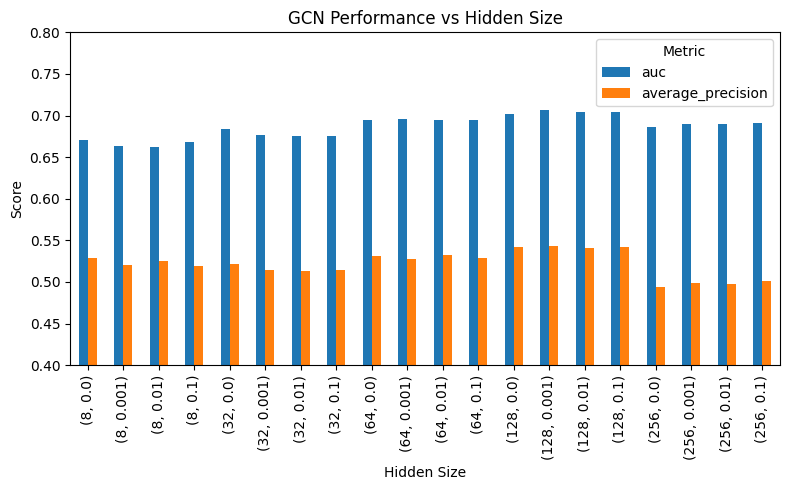

In [21]:
ax = df_res.plot(kind='bar', figsize=(8, 5))
plt.title("GCN Performance vs Hidden Size")
plt.xlabel("Hidden Size")
plt.ylabel("Score")
plt.ylim(0.4, 0.8)

plt.legend(title="Metric")
plt.tight_layout()
plt.show()